In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # or any {'0', '1', '2'}
from imagenet_dataset import get_dataset
from retina_env import RetinaEnv, calculate_retinal_filter
from rl_networks import create_actor_model, create_critic_model, policy
from rl_core import Buffer, update_target
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

import types
config = types.SimpleNamespace()
config.batch_size = 32
config.margin = 20
config.image_h = 224
config.image_w = 224
config.image_hm = config.image_h+2*config.margin
config.image_wm = config.image_w+2*config.margin
config.foveate = None
config.do_grayscale = True
config.history_length = 16
config.t_ignore = 16
config.t_max =50
config.motion_mode = 'velocity'

config.gym_mode = False
t_vec = np.linspace(0,150,16)

balanced_filter = calculate_retinal_filter(t_vec, R=1.0)
config.filter = balanced_filter.reshape([1,1,-1,1])
config.min_freq = 1
config.max_freq = 13
config.action_upper_bound = np.array([2.0, 2.0])

dataset_dir = '/home/bnapp/datasets/tensorflow_datasets/imagenet2012/5.0.0/'

def epsilon_scheduler(episode, floor_episode=200, epsilon_floor=0.1):
    if episode < floor_episode:
        return 1.-(1.-epsilon_floor)*episode/floor_episode
    else:
        return epsilon_floor

dataset = get_dataset(dataset_dir,
                                     'validation',
                                     config.batch_size,
                                     image_h = config.image_hm,
                                     image_w = config.image_wm,
                                     preprocessing='identity',
                                     rggb_mode=False,
                                     central_squeeze_and_pad_factor=-1)

env = RetinaEnv(config, image_generator=dataset)

if config.gym_mode:
    num_states = env.observation_space.shape[0]
    num_actions = env.action_space.shape[0]

    upper_bound = env.action_space.high[0]
    lower_bound = env.action_space.low[0]
else:
    num_states = env.observation_size
    num_actions = env.action_size
    upper_bound = env.action_upper_bound
    lower_bound = env.action_lower_bound

# You might want to adjust the hyperparameters
actor_lr = 0.001
critic_lr = 0.002
gamma = 0.99
tau = 0.005

buffer_capacity = 1000
batch_size = 64



# Create actor and critic networks
actor_model = create_actor_model(env.image_h, env.image_w, env.spectral_density_size, env.location_history_size, env.timestep_size, env.action_size)
critic_model = create_critic_model(env.image_h, env.image_w, env.spectral_density_size, env.location_history_size, env.timestep_size, env.action_size)

# Create target actor and critic networks
target_actor = create_actor_model(env.image_h, env.image_w, env.spectral_density_size, env.location_history_size, env.timestep_size, env.action_size)
target_critic = create_critic_model(env.image_h, env.image_w, env.spectral_density_size, env.location_history_size, env.timestep_size, env.action_size)

# Making the weights equal initially
target_actor.set_weights(actor_model.get_weights())
target_critic.set_weights(critic_model.get_weights())

# Learning rate for actor-critic models
critic_optimizer = tf.keras.optimizers.Adam(critic_lr)
actor_optimizer = tf.keras.optimizers.Adam(actor_lr)

# Experience replay buffer
buffer = Buffer(buffer_capacity, config.batch_size, num_states=num_states, num_actions=num_actions,
                state_reshape_fn=env.unflatten_observation)

/usr/local/lib/python3.8/dist-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.3.0 and strictly below 2.6.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.6.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


Instructions for updating:
Use `tf.data.Dataset.map(map_func, num_parallel_calls)` followed by `tf.data.Dataset.batch(batch_size, drop_remainder)`. Static tf.data optimizations will take care of using the fused implementation.


In [2]:
# Training loop
reward_records = []
epsilon_records = []
episodes = 1000
for ep in range(episodes):
    prev_state = env.reset()
    episodic_reward = 0
    epsilon = epsilon_scheduler(ep)

    while True:
        # tf_prev_state = tf.expand_dims(tf.convert_to_tensor(prev_state), 0)
        
        deterministic_action = policy(env.unflatten_observation(prev_state), actor_model, lower_bound, upper_bound)
        random_action = -2+4*np.random.uniform(size=(config.batch_size,2))

        if env.warmup_done:
            action = epsilon*random_action + (1-epsilon)*deterministic_action
        else:
            action = random_action

        # Recieve state and reward from environment
        state, reward, done, info = env.step(action)
        
        if env.warmup_done:
            buffer.record((prev_state, action, reward, state))
            episodic_reward += reward

            buffer.learn(actor_model, target_actor, critic_model, target_critic, actor_optimizer, critic_optimizer, gamma, tau)
            update_target(target_actor.variables, actor_model.variables, tau)
            update_target(target_critic.variables, critic_model.variables, tau)
        # End this episode when `done` is True
        if done:
            break

        #prev_state = state avoid assingment by reference:
        prev_state = np.copy(state)
#         print('debug action: ', action[0])

    print(f"Episode * {ep} * exploration epsilon {epsilon} * Episodic Reward is ==> {episodic_reward.numpy().mean()}")
    reward_records.append(episodic_reward.numpy().mean())
    epsilon_records.append(epsilon)

Episode * 0 * exploration epsilon 1.0 * Episodic Reward is ==> -8.319305419921875
Episode * 1 * exploration epsilon 0.9955 * Episodic Reward is ==> -8.803115844726562
Episode * 2 * exploration epsilon 0.991 * Episodic Reward is ==> -8.942822456359863
Episode * 3 * exploration epsilon 0.9865 * Episodic Reward is ==> -9.543319702148438
Episode * 4 * exploration epsilon 0.982 * Episodic Reward is ==> -10.942963600158691
Episode * 5 * exploration epsilon 0.9775 * Episodic Reward is ==> -10.556596755981445
Episode * 6 * exploration epsilon 0.973 * Episodic Reward is ==> -9.78366756439209
Episode * 7 * exploration epsilon 0.9685 * Episodic Reward is ==> -10.562836647033691
Episode * 8 * exploration epsilon 0.964 * Episodic Reward is ==> -8.852213859558105
Episode * 9 * exploration epsilon 0.9595 * Episodic Reward is ==> -10.755908012390137
Episode * 10 * exploration epsilon 0.955 * Episodic Reward is ==> -9.6644287109375
Episode * 11 * exploration epsilon 0.9505 * Episodic Reward is ==> -9.5

Episode * 24 * exploration epsilon 0.892 * Episodic Reward is ==> -9.664005279541016
Episode * 25 * exploration epsilon 0.8875 * Episodic Reward is ==> -8.81697940826416
Episode * 26 * exploration epsilon 0.883 * Episodic Reward is ==> -8.538905143737793
Episode * 27 * exploration epsilon 0.8785000000000001 * Episodic Reward is ==> -10.472712516784668
Episode * 28 * exploration epsilon 0.874 * Episodic Reward is ==> -9.847043991088867
Episode * 29 * exploration epsilon 0.8694999999999999 * Episodic Reward is ==> -8.531389236450195
Episode * 30 * exploration epsilon 0.865 * Episodic Reward is ==> -9.327533721923828
Episode * 31 * exploration epsilon 0.8605 * Episodic Reward is ==> -10.266386032104492
Episode * 32 * exploration epsilon 0.856 * Episodic Reward is ==> -9.350325584411621
Episode * 33 * exploration epsilon 0.8515 * Episodic Reward is ==> -9.929383277893066
Episode * 34 * exploration epsilon 0.847 * Episodic Reward is ==> -8.764735221862793
Episode * 35 * exploration epsilon 

Episode * 48 * exploration epsilon 0.784 * Episodic Reward is ==> -11.335397720336914
Episode * 49 * exploration epsilon 0.7795 * Episodic Reward is ==> -8.582971572875977
Episode * 50 * exploration epsilon 0.775 * Episodic Reward is ==> -9.087189674377441
Episode * 51 * exploration epsilon 0.7705 * Episodic Reward is ==> -8.6385498046875
Episode * 52 * exploration epsilon 0.766 * Episodic Reward is ==> -9.331048965454102
Episode * 53 * exploration epsilon 0.7615 * Episodic Reward is ==> -8.297992706298828
Episode * 54 * exploration epsilon 0.757 * Episodic Reward is ==> -9.5594482421875
Episode * 55 * exploration epsilon 0.7525 * Episodic Reward is ==> -8.278304100036621
Episode * 56 * exploration epsilon 0.748 * Episodic Reward is ==> -9.74547290802002
Episode * 57 * exploration epsilon 0.7435 * Episodic Reward is ==> -8.386102676391602
Episode * 58 * exploration epsilon 0.739 * Episodic Reward is ==> -9.396585464477539
Episode * 59 * exploration epsilon 0.7344999999999999 * Episodic

Episode * 72 * exploration epsilon 0.6759999999999999 * Episodic Reward is ==> -7.730081558227539
Episode * 73 * exploration epsilon 0.6715 * Episodic Reward is ==> -8.835108757019043
Episode * 74 * exploration epsilon 0.667 * Episodic Reward is ==> -9.972692489624023
Episode * 75 * exploration epsilon 0.6625 * Episodic Reward is ==> -7.881045818328857
Episode * 76 * exploration epsilon 0.6579999999999999 * Episodic Reward is ==> -9.159077644348145
Episode * 77 * exploration epsilon 0.6535 * Episodic Reward is ==> -9.638327598571777
Episode * 78 * exploration epsilon 0.649 * Episodic Reward is ==> -9.723142623901367
Episode * 79 * exploration epsilon 0.6445 * Episodic Reward is ==> -8.651949882507324
Episode * 80 * exploration epsilon 0.64 * Episodic Reward is ==> -8.864347457885742
Episode * 81 * exploration epsilon 0.6355 * Episodic Reward is ==> -9.531566619873047
Episode * 82 * exploration epsilon 0.631 * Episodic Reward is ==> -9.202323913574219
Episode * 83 * exploration epsilon 

Episode * 96 * exploration epsilon 0.568 * Episodic Reward is ==> -9.821439743041992
Episode * 97 * exploration epsilon 0.5635 * Episodic Reward is ==> -9.094335556030273
Episode * 98 * exploration epsilon 0.5589999999999999 * Episodic Reward is ==> -10.136940956115723
Episode * 99 * exploration epsilon 0.5545 * Episodic Reward is ==> -9.394645690917969
Episode * 100 * exploration epsilon 0.55 * Episodic Reward is ==> -9.198005676269531
Episode * 101 * exploration epsilon 0.5455 * Episodic Reward is ==> -9.100080490112305
Episode * 102 * exploration epsilon 0.541 * Episodic Reward is ==> -10.272138595581055
Episode * 103 * exploration epsilon 0.5365 * Episodic Reward is ==> -7.922938346862793
Episode * 104 * exploration epsilon 0.532 * Episodic Reward is ==> -10.356550216674805
Episode * 105 * exploration epsilon 0.5275000000000001 * Episodic Reward is ==> -8.674699783325195
Episode * 106 * exploration epsilon 0.5229999999999999 * Episodic Reward is ==> -8.386558532714844
Episode * 107

Episode * 120 * exploration epsilon 0.45999999999999996 * Episodic Reward is ==> -9.606630325317383
Episode * 121 * exploration epsilon 0.4555 * Episodic Reward is ==> -8.486370086669922
Episode * 122 * exploration epsilon 0.45100000000000007 * Episodic Reward is ==> -9.128463745117188
Episode * 123 * exploration epsilon 0.4465 * Episodic Reward is ==> -8.161919593811035
Episode * 124 * exploration epsilon 0.44199999999999995 * Episodic Reward is ==> -9.635986328125
Episode * 125 * exploration epsilon 0.4375 * Episodic Reward is ==> -10.312885284423828
Episode * 126 * exploration epsilon 0.43299999999999994 * Episodic Reward is ==> -7.429657936096191
Episode * 127 * exploration epsilon 0.4285 * Episodic Reward is ==> -9.658975601196289
Episode * 128 * exploration epsilon 0.42399999999999993 * Episodic Reward is ==> -12.641251564025879
Episode * 129 * exploration epsilon 0.4195 * Episodic Reward is ==> -9.275556564331055
Episode * 130 * exploration epsilon 0.41500000000000004 * Episodic

Episode * 143 * exploration epsilon 0.35649999999999993 * Episodic Reward is ==> -7.796081066131592
Episode * 144 * exploration epsilon 0.352 * Episodic Reward is ==> -10.33122444152832
Episode * 145 * exploration epsilon 0.34750000000000003 * Episodic Reward is ==> -8.170612335205078
Episode * 146 * exploration epsilon 0.34299999999999997 * Episodic Reward is ==> -9.457084655761719
Episode * 147 * exploration epsilon 0.3384999999999999 * Episodic Reward is ==> -9.208410263061523
Episode * 148 * exploration epsilon 0.33399999999999996 * Episodic Reward is ==> -9.354452133178711
Episode * 149 * exploration epsilon 0.3295 * Episodic Reward is ==> -9.037790298461914
Episode * 150 * exploration epsilon 0.32499999999999996 * Episodic Reward is ==> -9.143853187561035
Episode * 151 * exploration epsilon 0.3205 * Episodic Reward is ==> -8.978742599487305
Episode * 152 * exploration epsilon 0.31599999999999995 * Episodic Reward is ==> -8.623493194580078
Episode * 153 * exploration epsilon 0.311

Episode * 167 * exploration epsilon 0.24849999999999994 * Episodic Reward is ==> -9.109493255615234
Episode * 168 * exploration epsilon 0.24399999999999988 * Episodic Reward is ==> -9.341243743896484
Episode * 169 * exploration epsilon 0.23950000000000005 * Episodic Reward is ==> -9.20120906829834
Episode * 170 * exploration epsilon 0.235 * Episodic Reward is ==> -8.187569618225098
Episode * 171 * exploration epsilon 0.23049999999999993 * Episodic Reward is ==> -8.284662246704102
Episode * 172 * exploration epsilon 0.22599999999999998 * Episodic Reward is ==> -9.895872116088867
Episode * 173 * exploration epsilon 0.22149999999999992 * Episodic Reward is ==> -8.666178703308105
Episode * 174 * exploration epsilon 0.21700000000000008 * Episodic Reward is ==> -10.55119800567627
Episode * 175 * exploration epsilon 0.21250000000000002 * Episodic Reward is ==> -8.618356704711914
Episode * 176 * exploration epsilon 0.20799999999999996 * Episodic Reward is ==> -9.887688636779785
Episode * 177 *

Episode * 190 * exploration epsilon 0.14500000000000002 * Episodic Reward is ==> -9.486417770385742
Episode * 191 * exploration epsilon 0.14049999999999996 * Episodic Reward is ==> -10.489164352416992
Episode * 192 * exploration epsilon 0.1359999999999999 * Episodic Reward is ==> -8.185215950012207
Episode * 193 * exploration epsilon 0.13149999999999995 * Episodic Reward is ==> -8.62735652923584
Episode * 194 * exploration epsilon 0.127 * Episodic Reward is ==> -8.986119270324707
Episode * 195 * exploration epsilon 0.12250000000000005 * Episodic Reward is ==> -8.666187286376953
Episode * 196 * exploration epsilon 0.118 * Episodic Reward is ==> -10.227977752685547
Episode * 197 * exploration epsilon 0.11349999999999993 * Episodic Reward is ==> -8.002541542053223
Episode * 198 * exploration epsilon 0.10899999999999987 * Episodic Reward is ==> -9.138874053955078
Episode * 199 * exploration epsilon 0.10450000000000004 * Episodic Reward is ==> -9.418731689453125
Episode * 200 * exploration 

Episode * 214 * exploration epsilon 0.1 * Episodic Reward is ==> -8.666374206542969
Episode * 215 * exploration epsilon 0.1 * Episodic Reward is ==> -8.79828929901123
Episode * 216 * exploration epsilon 0.1 * Episodic Reward is ==> -10.74009895324707
Episode * 217 * exploration epsilon 0.1 * Episodic Reward is ==> -8.732675552368164
Episode * 218 * exploration epsilon 0.1 * Episodic Reward is ==> -9.961841583251953
Episode * 219 * exploration epsilon 0.1 * Episodic Reward is ==> -8.032491683959961
Episode * 220 * exploration epsilon 0.1 * Episodic Reward is ==> -10.473068237304688
Episode * 221 * exploration epsilon 0.1 * Episodic Reward is ==> -9.280757904052734
Episode * 222 * exploration epsilon 0.1 * Episodic Reward is ==> -8.350319862365723
Episode * 223 * exploration epsilon 0.1 * Episodic Reward is ==> -8.980630874633789
Episode * 224 * exploration epsilon 0.1 * Episodic Reward is ==> -9.682920455932617
Episode * 225 * exploration epsilon 0.1 * Episodic Reward is ==> -8.61495113

Episode * 238 * exploration epsilon 0.1 * Episodic Reward is ==> -9.904380798339844
Episode * 239 * exploration epsilon 0.1 * Episodic Reward is ==> -8.870773315429688
Episode * 240 * exploration epsilon 0.1 * Episodic Reward is ==> -8.136743545532227
Episode * 241 * exploration epsilon 0.1 * Episodic Reward is ==> -8.979238510131836
Episode * 242 * exploration epsilon 0.1 * Episodic Reward is ==> -11.183517456054688
Episode * 243 * exploration epsilon 0.1 * Episodic Reward is ==> -8.111634254455566
Episode * 244 * exploration epsilon 0.1 * Episodic Reward is ==> -10.281633377075195
Episode * 245 * exploration epsilon 0.1 * Episodic Reward is ==> -9.822803497314453
Episode * 246 * exploration epsilon 0.1 * Episodic Reward is ==> -8.708267211914062
Episode * 247 * exploration epsilon 0.1 * Episodic Reward is ==> -10.505659103393555
Episode * 248 * exploration epsilon 0.1 * Episodic Reward is ==> -8.679128646850586
Episode * 249 * exploration epsilon 0.1 * Episodic Reward is ==> -9.21984

Episode * 262 * exploration epsilon 0.1 * Episodic Reward is ==> -9.417057037353516
Episode * 263 * exploration epsilon 0.1 * Episodic Reward is ==> -7.715985298156738
Episode * 264 * exploration epsilon 0.1 * Episodic Reward is ==> -10.08749771118164
Episode * 265 * exploration epsilon 0.1 * Episodic Reward is ==> -8.430815696716309
Episode * 266 * exploration epsilon 0.1 * Episodic Reward is ==> -10.571415901184082
Episode * 267 * exploration epsilon 0.1 * Episodic Reward is ==> -8.785863876342773
Episode * 268 * exploration epsilon 0.1 * Episodic Reward is ==> -7.935792446136475
Episode * 269 * exploration epsilon 0.1 * Episodic Reward is ==> -9.202009201049805
Episode * 270 * exploration epsilon 0.1 * Episodic Reward is ==> -10.059867858886719
Episode * 271 * exploration epsilon 0.1 * Episodic Reward is ==> -9.025091171264648
Episode * 272 * exploration epsilon 0.1 * Episodic Reward is ==> -8.427116394042969
Episode * 273 * exploration epsilon 0.1 * Episodic Reward is ==> -9.374050

Episode * 286 * exploration epsilon 0.1 * Episodic Reward is ==> -9.563350677490234
Episode * 287 * exploration epsilon 0.1 * Episodic Reward is ==> -10.133949279785156
Episode * 288 * exploration epsilon 0.1 * Episodic Reward is ==> -8.042055130004883
Episode * 289 * exploration epsilon 0.1 * Episodic Reward is ==> -9.490541458129883
Episode * 290 * exploration epsilon 0.1 * Episodic Reward is ==> -8.713834762573242
Episode * 291 * exploration epsilon 0.1 * Episodic Reward is ==> -9.354390144348145
Episode * 292 * exploration epsilon 0.1 * Episodic Reward is ==> -8.72822380065918
Episode * 293 * exploration epsilon 0.1 * Episodic Reward is ==> -9.088613510131836
Episode * 294 * exploration epsilon 0.1 * Episodic Reward is ==> -8.601274490356445
Episode * 295 * exploration epsilon 0.1 * Episodic Reward is ==> -7.991237163543701
Episode * 296 * exploration epsilon 0.1 * Episodic Reward is ==> -6.963334083557129
Episode * 297 * exploration epsilon 0.1 * Episodic Reward is ==> -9.56310844

Episode * 310 * exploration epsilon 0.1 * Episodic Reward is ==> -9.826972961425781
Episode * 311 * exploration epsilon 0.1 * Episodic Reward is ==> -8.796133995056152
Episode * 312 * exploration epsilon 0.1 * Episodic Reward is ==> -8.807254791259766
Episode * 313 * exploration epsilon 0.1 * Episodic Reward is ==> -9.859086990356445
Episode * 314 * exploration epsilon 0.1 * Episodic Reward is ==> -8.426994323730469
Episode * 315 * exploration epsilon 0.1 * Episodic Reward is ==> -10.370522499084473
Episode * 316 * exploration epsilon 0.1 * Episodic Reward is ==> -9.1121826171875
Episode * 317 * exploration epsilon 0.1 * Episodic Reward is ==> -8.994318008422852
Episode * 318 * exploration epsilon 0.1 * Episodic Reward is ==> -8.025749206542969
Episode * 319 * exploration epsilon 0.1 * Episodic Reward is ==> -8.16958236694336
Episode * 320 * exploration epsilon 0.1 * Episodic Reward is ==> -9.591641426086426
Episode * 321 * exploration epsilon 0.1 * Episodic Reward is ==> -8.8445415496

Episode * 334 * exploration epsilon 0.1 * Episodic Reward is ==> -7.800734996795654
Episode * 335 * exploration epsilon 0.1 * Episodic Reward is ==> -8.342870712280273
Episode * 336 * exploration epsilon 0.1 * Episodic Reward is ==> -8.546236038208008
Episode * 337 * exploration epsilon 0.1 * Episodic Reward is ==> -7.5773773193359375
Episode * 338 * exploration epsilon 0.1 * Episodic Reward is ==> -10.017974853515625
Episode * 339 * exploration epsilon 0.1 * Episodic Reward is ==> -10.170246124267578
Episode * 340 * exploration epsilon 0.1 * Episodic Reward is ==> -7.255636215209961
Episode * 341 * exploration epsilon 0.1 * Episodic Reward is ==> -8.924413681030273
Episode * 342 * exploration epsilon 0.1 * Episodic Reward is ==> -8.00521183013916
Episode * 343 * exploration epsilon 0.1 * Episodic Reward is ==> -9.629907608032227
Episode * 344 * exploration epsilon 0.1 * Episodic Reward is ==> -10.771297454833984
Episode * 345 * exploration epsilon 0.1 * Episodic Reward is ==> -10.2527

Episode * 358 * exploration epsilon 0.1 * Episodic Reward is ==> -11.44347095489502
Episode * 359 * exploration epsilon 0.1 * Episodic Reward is ==> -10.614219665527344
Episode * 360 * exploration epsilon 0.1 * Episodic Reward is ==> -9.232048988342285
Episode * 361 * exploration epsilon 0.1 * Episodic Reward is ==> -9.478212356567383
Episode * 362 * exploration epsilon 0.1 * Episodic Reward is ==> -9.18457317352295
Episode * 363 * exploration epsilon 0.1 * Episodic Reward is ==> -8.831931114196777
Episode * 364 * exploration epsilon 0.1 * Episodic Reward is ==> -7.4215216636657715
Episode * 365 * exploration epsilon 0.1 * Episodic Reward is ==> -9.574798583984375
Episode * 366 * exploration epsilon 0.1 * Episodic Reward is ==> -7.824223518371582
Episode * 367 * exploration epsilon 0.1 * Episodic Reward is ==> -9.711435317993164
Episode * 368 * exploration epsilon 0.1 * Episodic Reward is ==> -8.064807891845703
Episode * 369 * exploration epsilon 0.1 * Episodic Reward is ==> -8.6690683

Episode * 382 * exploration epsilon 0.1 * Episodic Reward is ==> -10.387014389038086
Episode * 383 * exploration epsilon 0.1 * Episodic Reward is ==> -9.834053039550781
Episode * 384 * exploration epsilon 0.1 * Episodic Reward is ==> -10.341763496398926
Episode * 385 * exploration epsilon 0.1 * Episodic Reward is ==> -9.676268577575684
Episode * 386 * exploration epsilon 0.1 * Episodic Reward is ==> -9.763717651367188
Episode * 387 * exploration epsilon 0.1 * Episodic Reward is ==> -9.090177536010742
Episode * 388 * exploration epsilon 0.1 * Episodic Reward is ==> -8.402914047241211
Episode * 389 * exploration epsilon 0.1 * Episodic Reward is ==> -9.079397201538086
Episode * 390 * exploration epsilon 0.1 * Episodic Reward is ==> -8.932336807250977
Episode * 391 * exploration epsilon 0.1 * Episodic Reward is ==> -9.183687210083008
Episode * 392 * exploration epsilon 0.1 * Episodic Reward is ==> -8.214682579040527
Episode * 393 * exploration epsilon 0.1 * Episodic Reward is ==> -10.27882

Episode * 406 * exploration epsilon 0.1 * Episodic Reward is ==> -8.811304092407227
Episode * 407 * exploration epsilon 0.1 * Episodic Reward is ==> -8.566668510437012
Episode * 408 * exploration epsilon 0.1 * Episodic Reward is ==> -9.878865242004395
Episode * 409 * exploration epsilon 0.1 * Episodic Reward is ==> -9.857089042663574
Episode * 410 * exploration epsilon 0.1 * Episodic Reward is ==> -9.769275665283203
Episode * 411 * exploration epsilon 0.1 * Episodic Reward is ==> -9.537008285522461
Episode * 412 * exploration epsilon 0.1 * Episodic Reward is ==> -9.344215393066406
Episode * 413 * exploration epsilon 0.1 * Episodic Reward is ==> -8.991418838500977
Episode * 414 * exploration epsilon 0.1 * Episodic Reward is ==> -9.83559799194336
Episode * 415 * exploration epsilon 0.1 * Episodic Reward is ==> -8.364628791809082
Episode * 416 * exploration epsilon 0.1 * Episodic Reward is ==> -8.427108764648438
Episode * 417 * exploration epsilon 0.1 * Episodic Reward is ==> -8.447027206

Episode * 430 * exploration epsilon 0.1 * Episodic Reward is ==> -10.441215515136719
Episode * 431 * exploration epsilon 0.1 * Episodic Reward is ==> -9.29446792602539
Episode * 432 * exploration epsilon 0.1 * Episodic Reward is ==> -10.174638748168945
Episode * 433 * exploration epsilon 0.1 * Episodic Reward is ==> -7.954498767852783
Episode * 434 * exploration epsilon 0.1 * Episodic Reward is ==> -9.304801940917969
Episode * 435 * exploration epsilon 0.1 * Episodic Reward is ==> -9.919509887695312
Episode * 436 * exploration epsilon 0.1 * Episodic Reward is ==> -9.797592163085938
Episode * 437 * exploration epsilon 0.1 * Episodic Reward is ==> -9.093368530273438
Episode * 438 * exploration epsilon 0.1 * Episodic Reward is ==> -9.05670166015625
Episode * 439 * exploration epsilon 0.1 * Episodic Reward is ==> -10.106515884399414
Episode * 440 * exploration epsilon 0.1 * Episodic Reward is ==> -8.995969772338867
Episode * 441 * exploration epsilon 0.1 * Episodic Reward is ==> -9.1932106

Episode * 454 * exploration epsilon 0.1 * Episodic Reward is ==> -8.950210571289062
Episode * 455 * exploration epsilon 0.1 * Episodic Reward is ==> -10.384515762329102
Episode * 456 * exploration epsilon 0.1 * Episodic Reward is ==> -9.563272476196289
Episode * 457 * exploration epsilon 0.1 * Episodic Reward is ==> -10.50521469116211
Episode * 458 * exploration epsilon 0.1 * Episodic Reward is ==> -10.680708885192871
Episode * 459 * exploration epsilon 0.1 * Episodic Reward is ==> -10.817790031433105
Episode * 460 * exploration epsilon 0.1 * Episodic Reward is ==> -7.343080997467041
Episode * 461 * exploration epsilon 0.1 * Episodic Reward is ==> -8.955251693725586
Episode * 462 * exploration epsilon 0.1 * Episodic Reward is ==> -8.785163879394531
Episode * 463 * exploration epsilon 0.1 * Episodic Reward is ==> -8.168634414672852
Episode * 464 * exploration epsilon 0.1 * Episodic Reward is ==> -7.994052886962891
Episode * 465 * exploration epsilon 0.1 * Episodic Reward is ==> -9.76797

Episode * 478 * exploration epsilon 0.1 * Episodic Reward is ==> -9.27470588684082
Episode * 479 * exploration epsilon 0.1 * Episodic Reward is ==> -9.736132621765137
Episode * 480 * exploration epsilon 0.1 * Episodic Reward is ==> -11.246940612792969
Episode * 481 * exploration epsilon 0.1 * Episodic Reward is ==> -8.76066780090332
Episode * 482 * exploration epsilon 0.1 * Episodic Reward is ==> -8.962730407714844
Episode * 483 * exploration epsilon 0.1 * Episodic Reward is ==> -9.036465644836426
Episode * 484 * exploration epsilon 0.1 * Episodic Reward is ==> -9.38119888305664
Episode * 485 * exploration epsilon 0.1 * Episodic Reward is ==> -8.900586128234863
Episode * 486 * exploration epsilon 0.1 * Episodic Reward is ==> -8.661131858825684
Episode * 487 * exploration epsilon 0.1 * Episodic Reward is ==> -8.099739074707031
Episode * 488 * exploration epsilon 0.1 * Episodic Reward is ==> -8.806894302368164
Episode * 489 * exploration epsilon 0.1 * Episodic Reward is ==> -9.4752845764

Episode * 502 * exploration epsilon 0.1 * Episodic Reward is ==> -8.37613296508789
Episode * 503 * exploration epsilon 0.1 * Episodic Reward is ==> -9.244129180908203
Episode * 504 * exploration epsilon 0.1 * Episodic Reward is ==> -9.467690467834473
Episode * 505 * exploration epsilon 0.1 * Episodic Reward is ==> -8.89943790435791
Episode * 506 * exploration epsilon 0.1 * Episodic Reward is ==> -9.286449432373047
Episode * 507 * exploration epsilon 0.1 * Episodic Reward is ==> -9.334494590759277
Episode * 508 * exploration epsilon 0.1 * Episodic Reward is ==> -9.868141174316406
Episode * 509 * exploration epsilon 0.1 * Episodic Reward is ==> -8.895692825317383
Episode * 510 * exploration epsilon 0.1 * Episodic Reward is ==> -8.742313385009766
Episode * 511 * exploration epsilon 0.1 * Episodic Reward is ==> -8.335289001464844
Episode * 512 * exploration epsilon 0.1 * Episodic Reward is ==> -8.675386428833008
Episode * 513 * exploration epsilon 0.1 * Episodic Reward is ==> -9.5235595703

Episode * 526 * exploration epsilon 0.1 * Episodic Reward is ==> -9.015848159790039
Episode * 527 * exploration epsilon 0.1 * Episodic Reward is ==> -9.828536987304688
Episode * 528 * exploration epsilon 0.1 * Episodic Reward is ==> -8.719047546386719
Episode * 529 * exploration epsilon 0.1 * Episodic Reward is ==> -9.757588386535645
Episode * 530 * exploration epsilon 0.1 * Episodic Reward is ==> -8.736820220947266
Episode * 531 * exploration epsilon 0.1 * Episodic Reward is ==> -7.490264892578125
Episode * 532 * exploration epsilon 0.1 * Episodic Reward is ==> -8.686092376708984
Episode * 533 * exploration epsilon 0.1 * Episodic Reward is ==> -9.077438354492188
Episode * 534 * exploration epsilon 0.1 * Episodic Reward is ==> -8.58978271484375
Episode * 535 * exploration epsilon 0.1 * Episodic Reward is ==> -8.660991668701172
Episode * 536 * exploration epsilon 0.1 * Episodic Reward is ==> -9.668668746948242
Episode * 537 * exploration epsilon 0.1 * Episodic Reward is ==> -8.071399688

Episode * 550 * exploration epsilon 0.1 * Episodic Reward is ==> -10.767932891845703
Episode * 551 * exploration epsilon 0.1 * Episodic Reward is ==> -7.9039812088012695
Episode * 552 * exploration epsilon 0.1 * Episodic Reward is ==> -9.182174682617188
Episode * 553 * exploration epsilon 0.1 * Episodic Reward is ==> -9.258849143981934
Episode * 554 * exploration epsilon 0.1 * Episodic Reward is ==> -9.23897647857666
Episode * 555 * exploration epsilon 0.1 * Episodic Reward is ==> -8.465777397155762
Episode * 556 * exploration epsilon 0.1 * Episodic Reward is ==> -10.614571571350098
Episode * 557 * exploration epsilon 0.1 * Episodic Reward is ==> -9.087641716003418
Episode * 558 * exploration epsilon 0.1 * Episodic Reward is ==> -10.477303504943848
Episode * 559 * exploration epsilon 0.1 * Episodic Reward is ==> -9.90112590789795
Episode * 560 * exploration epsilon 0.1 * Episodic Reward is ==> -10.146652221679688
Episode * 561 * exploration epsilon 0.1 * Episodic Reward is ==> -11.8439

Episode * 574 * exploration epsilon 0.1 * Episodic Reward is ==> -12.648846626281738
Episode * 575 * exploration epsilon 0.1 * Episodic Reward is ==> -13.366230964660645
Episode * 576 * exploration epsilon 0.1 * Episodic Reward is ==> -10.557512283325195
Episode * 577 * exploration epsilon 0.1 * Episodic Reward is ==> -11.127533912658691
Episode * 578 * exploration epsilon 0.1 * Episodic Reward is ==> -10.971538543701172
Episode * 579 * exploration epsilon 0.1 * Episodic Reward is ==> -11.164846420288086
Episode * 580 * exploration epsilon 0.1 * Episodic Reward is ==> -9.6775484085083
Episode * 581 * exploration epsilon 0.1 * Episodic Reward is ==> -10.733851432800293
Episode * 582 * exploration epsilon 0.1 * Episodic Reward is ==> -9.394287109375
Episode * 583 * exploration epsilon 0.1 * Episodic Reward is ==> -9.728918075561523
Episode * 584 * exploration epsilon 0.1 * Episodic Reward is ==> -10.576505661010742
Episode * 585 * exploration epsilon 0.1 * Episodic Reward is ==> -8.83850

Episode * 598 * exploration epsilon 0.1 * Episodic Reward is ==> -9.88205337524414
Episode * 599 * exploration epsilon 0.1 * Episodic Reward is ==> -8.697776794433594
Episode * 600 * exploration epsilon 0.1 * Episodic Reward is ==> -12.419841766357422
Episode * 601 * exploration epsilon 0.1 * Episodic Reward is ==> -8.892654418945312
Episode * 602 * exploration epsilon 0.1 * Episodic Reward is ==> -9.0794095993042
Episode * 603 * exploration epsilon 0.1 * Episodic Reward is ==> -9.011960983276367
Episode * 604 * exploration epsilon 0.1 * Episodic Reward is ==> -8.640670776367188
Episode * 605 * exploration epsilon 0.1 * Episodic Reward is ==> -9.27324104309082
Episode * 606 * exploration epsilon 0.1 * Episodic Reward is ==> -7.853092670440674
Episode * 607 * exploration epsilon 0.1 * Episodic Reward is ==> -8.829882621765137
Episode * 608 * exploration epsilon 0.1 * Episodic Reward is ==> -9.888587951660156
Episode * 609 * exploration epsilon 0.1 * Episodic Reward is ==> -7.94529914855

Episode * 622 * exploration epsilon 0.1 * Episodic Reward is ==> -7.527374744415283
Episode * 623 * exploration epsilon 0.1 * Episodic Reward is ==> -9.510583877563477
Episode * 624 * exploration epsilon 0.1 * Episodic Reward is ==> -8.763055801391602
Episode * 625 * exploration epsilon 0.1 * Episodic Reward is ==> -8.8782958984375
Episode * 626 * exploration epsilon 0.1 * Episodic Reward is ==> -9.889507293701172
Episode * 627 * exploration epsilon 0.1 * Episodic Reward is ==> -10.357873916625977
Episode * 628 * exploration epsilon 0.1 * Episodic Reward is ==> -8.810014724731445
Episode * 629 * exploration epsilon 0.1 * Episodic Reward is ==> -10.012092590332031
Episode * 630 * exploration epsilon 0.1 * Episodic Reward is ==> -7.469082832336426
Episode * 631 * exploration epsilon 0.1 * Episodic Reward is ==> -9.969242095947266
Episode * 632 * exploration epsilon 0.1 * Episodic Reward is ==> -9.466789245605469
Episode * 633 * exploration epsilon 0.1 * Episodic Reward is ==> -9.45106506

Episode * 646 * exploration epsilon 0.1 * Episodic Reward is ==> -9.41579818725586
Episode * 647 * exploration epsilon 0.1 * Episodic Reward is ==> -7.683937072753906
Episode * 648 * exploration epsilon 0.1 * Episodic Reward is ==> -9.835885047912598
Episode * 649 * exploration epsilon 0.1 * Episodic Reward is ==> -10.397741317749023
Episode * 650 * exploration epsilon 0.1 * Episodic Reward is ==> -10.048337936401367
Episode * 651 * exploration epsilon 0.1 * Episodic Reward is ==> -8.296014785766602
Episode * 652 * exploration epsilon 0.1 * Episodic Reward is ==> -8.543655395507812
Episode * 653 * exploration epsilon 0.1 * Episodic Reward is ==> -9.236032485961914
Episode * 654 * exploration epsilon 0.1 * Episodic Reward is ==> -8.949309349060059
Episode * 655 * exploration epsilon 0.1 * Episodic Reward is ==> -8.379514694213867
Episode * 656 * exploration epsilon 0.1 * Episodic Reward is ==> -8.161590576171875
Episode * 657 * exploration epsilon 0.1 * Episodic Reward is ==> -11.292729

Episode * 670 * exploration epsilon 0.1 * Episodic Reward is ==> -10.531673431396484
Episode * 671 * exploration epsilon 0.1 * Episodic Reward is ==> -9.021194458007812
Episode * 672 * exploration epsilon 0.1 * Episodic Reward is ==> -9.92677116394043
Episode * 673 * exploration epsilon 0.1 * Episodic Reward is ==> -8.623205184936523
Episode * 674 * exploration epsilon 0.1 * Episodic Reward is ==> -10.043222427368164
Episode * 675 * exploration epsilon 0.1 * Episodic Reward is ==> -7.919976234436035
Episode * 676 * exploration epsilon 0.1 * Episodic Reward is ==> -8.954570770263672
Episode * 677 * exploration epsilon 0.1 * Episodic Reward is ==> -8.844273567199707
Episode * 678 * exploration epsilon 0.1 * Episodic Reward is ==> -10.638301849365234
Episode * 679 * exploration epsilon 0.1 * Episodic Reward is ==> -8.723386764526367
Episode * 680 * exploration epsilon 0.1 * Episodic Reward is ==> -9.268571853637695
Episode * 681 * exploration epsilon 0.1 * Episodic Reward is ==> -9.418251

Episode * 694 * exploration epsilon 0.1 * Episodic Reward is ==> -10.059823989868164
Episode * 695 * exploration epsilon 0.1 * Episodic Reward is ==> -7.678313255310059
Episode * 696 * exploration epsilon 0.1 * Episodic Reward is ==> -9.84579086303711
Episode * 697 * exploration epsilon 0.1 * Episodic Reward is ==> -7.735528945922852
Episode * 698 * exploration epsilon 0.1 * Episodic Reward is ==> -9.042022705078125
Episode * 699 * exploration epsilon 0.1 * Episodic Reward is ==> -10.256885528564453
Episode * 700 * exploration epsilon 0.1 * Episodic Reward is ==> -10.149961471557617
Episode * 701 * exploration epsilon 0.1 * Episodic Reward is ==> -9.249366760253906
Episode * 702 * exploration epsilon 0.1 * Episodic Reward is ==> -9.477472305297852
Episode * 703 * exploration epsilon 0.1 * Episodic Reward is ==> -9.412843704223633
Episode * 704 * exploration epsilon 0.1 * Episodic Reward is ==> -7.498851776123047
Episode * 705 * exploration epsilon 0.1 * Episodic Reward is ==> -8.517214

Episode * 718 * exploration epsilon 0.1 * Episodic Reward is ==> -9.47238826751709
Episode * 719 * exploration epsilon 0.1 * Episodic Reward is ==> -7.682448387145996
Episode * 720 * exploration epsilon 0.1 * Episodic Reward is ==> -10.333513259887695
Episode * 721 * exploration epsilon 0.1 * Episodic Reward is ==> -9.56042194366455
Episode * 722 * exploration epsilon 0.1 * Episodic Reward is ==> -9.412271499633789
Episode * 723 * exploration epsilon 0.1 * Episodic Reward is ==> -8.06397819519043
Episode * 724 * exploration epsilon 0.1 * Episodic Reward is ==> -10.391403198242188
Episode * 725 * exploration epsilon 0.1 * Episodic Reward is ==> -9.70026683807373
Episode * 726 * exploration epsilon 0.1 * Episodic Reward is ==> -9.807907104492188
Episode * 727 * exploration epsilon 0.1 * Episodic Reward is ==> -10.103925704956055
Episode * 728 * exploration epsilon 0.1 * Episodic Reward is ==> -10.156888961791992
Episode * 729 * exploration epsilon 0.1 * Episodic Reward is ==> -11.0165777

Episode * 742 * exploration epsilon 0.1 * Episodic Reward is ==> -12.607440948486328
Episode * 743 * exploration epsilon 0.1 * Episodic Reward is ==> -12.779596328735352
Episode * 744 * exploration epsilon 0.1 * Episodic Reward is ==> -12.016016960144043
Episode * 745 * exploration epsilon 0.1 * Episodic Reward is ==> -13.961644172668457
Episode * 746 * exploration epsilon 0.1 * Episodic Reward is ==> -14.036506652832031
Episode * 747 * exploration epsilon 0.1 * Episodic Reward is ==> -13.207586288452148
Episode * 748 * exploration epsilon 0.1 * Episodic Reward is ==> -12.358785629272461
Episode * 749 * exploration epsilon 0.1 * Episodic Reward is ==> -13.691429138183594
Episode * 750 * exploration epsilon 0.1 * Episodic Reward is ==> -14.035202026367188
Episode * 751 * exploration epsilon 0.1 * Episodic Reward is ==> -13.229181289672852
Episode * 752 * exploration epsilon 0.1 * Episodic Reward is ==> -14.876699447631836
Episode * 753 * exploration epsilon 0.1 * Episodic Reward is ==> 

Episode * 766 * exploration epsilon 0.1 * Episodic Reward is ==> -11.629692077636719
Episode * 767 * exploration epsilon 0.1 * Episodic Reward is ==> -12.085356712341309
Episode * 768 * exploration epsilon 0.1 * Episodic Reward is ==> -11.742632865905762
Episode * 769 * exploration epsilon 0.1 * Episodic Reward is ==> -10.393585205078125
Episode * 770 * exploration epsilon 0.1 * Episodic Reward is ==> -10.817261695861816
Episode * 771 * exploration epsilon 0.1 * Episodic Reward is ==> -8.576984405517578
Episode * 772 * exploration epsilon 0.1 * Episodic Reward is ==> -10.289443969726562
Episode * 773 * exploration epsilon 0.1 * Episodic Reward is ==> -10.561203002929688
Episode * 774 * exploration epsilon 0.1 * Episodic Reward is ==> -9.522642135620117
Episode * 775 * exploration epsilon 0.1 * Episodic Reward is ==> -10.30200481414795
Episode * 776 * exploration epsilon 0.1 * Episodic Reward is ==> -9.10804557800293
Episode * 777 * exploration epsilon 0.1 * Episodic Reward is ==> -9.46

Episode * 790 * exploration epsilon 0.1 * Episodic Reward is ==> -11.226064682006836
Episode * 791 * exploration epsilon 0.1 * Episodic Reward is ==> -8.799402236938477
Episode * 792 * exploration epsilon 0.1 * Episodic Reward is ==> -10.876958847045898
Episode * 793 * exploration epsilon 0.1 * Episodic Reward is ==> -8.357072830200195
Episode * 794 * exploration epsilon 0.1 * Episodic Reward is ==> -8.370902061462402
Episode * 795 * exploration epsilon 0.1 * Episodic Reward is ==> -9.168825149536133
Episode * 796 * exploration epsilon 0.1 * Episodic Reward is ==> -8.760551452636719
Episode * 797 * exploration epsilon 0.1 * Episodic Reward is ==> -9.203084945678711
Episode * 798 * exploration epsilon 0.1 * Episodic Reward is ==> -9.231252670288086
Episode * 799 * exploration epsilon 0.1 * Episodic Reward is ==> -10.113582611083984
Episode * 800 * exploration epsilon 0.1 * Episodic Reward is ==> -8.611976623535156
Episode * 801 * exploration epsilon 0.1 * Episodic Reward is ==> -8.30436

Episode * 814 * exploration epsilon 0.1 * Episodic Reward is ==> -9.114181518554688
Episode * 815 * exploration epsilon 0.1 * Episodic Reward is ==> -9.404695510864258
Episode * 816 * exploration epsilon 0.1 * Episodic Reward is ==> -9.137334823608398
Episode * 817 * exploration epsilon 0.1 * Episodic Reward is ==> -11.392491340637207
Episode * 818 * exploration epsilon 0.1 * Episodic Reward is ==> -10.700660705566406
Episode * 819 * exploration epsilon 0.1 * Episodic Reward is ==> -10.909034729003906
Episode * 820 * exploration epsilon 0.1 * Episodic Reward is ==> -11.294591903686523
Episode * 821 * exploration epsilon 0.1 * Episodic Reward is ==> -12.149114608764648
Episode * 822 * exploration epsilon 0.1 * Episodic Reward is ==> -10.696884155273438
Episode * 823 * exploration epsilon 0.1 * Episodic Reward is ==> -12.132866859436035
Episode * 824 * exploration epsilon 0.1 * Episodic Reward is ==> -10.865160942077637
Episode * 825 * exploration epsilon 0.1 * Episodic Reward is ==> -11

Episode * 838 * exploration epsilon 0.1 * Episodic Reward is ==> -10.374785423278809
Episode * 839 * exploration epsilon 0.1 * Episodic Reward is ==> -10.14640998840332
Episode * 840 * exploration epsilon 0.1 * Episodic Reward is ==> -9.103927612304688
Episode * 841 * exploration epsilon 0.1 * Episodic Reward is ==> -9.556884765625
Episode * 842 * exploration epsilon 0.1 * Episodic Reward is ==> -10.195220947265625
Episode * 843 * exploration epsilon 0.1 * Episodic Reward is ==> -11.491617202758789
Episode * 844 * exploration epsilon 0.1 * Episodic Reward is ==> -10.412559509277344
Episode * 845 * exploration epsilon 0.1 * Episodic Reward is ==> -8.462546348571777
Episode * 846 * exploration epsilon 0.1 * Episodic Reward is ==> -9.567596435546875
Episode * 847 * exploration epsilon 0.1 * Episodic Reward is ==> -11.262802124023438
Episode * 848 * exploration epsilon 0.1 * Episodic Reward is ==> -8.783010482788086
Episode * 849 * exploration epsilon 0.1 * Episodic Reward is ==> -10.84481

Episode * 862 * exploration epsilon 0.1 * Episodic Reward is ==> -8.238543510437012
Episode * 863 * exploration epsilon 0.1 * Episodic Reward is ==> -9.356407165527344
Episode * 864 * exploration epsilon 0.1 * Episodic Reward is ==> -9.921808242797852
Episode * 865 * exploration epsilon 0.1 * Episodic Reward is ==> -8.961965560913086
Episode * 866 * exploration epsilon 0.1 * Episodic Reward is ==> -10.347883224487305
Episode * 867 * exploration epsilon 0.1 * Episodic Reward is ==> -9.55827808380127
Episode * 868 * exploration epsilon 0.1 * Episodic Reward is ==> -9.823579788208008
Episode * 869 * exploration epsilon 0.1 * Episodic Reward is ==> -10.664369583129883
Episode * 870 * exploration epsilon 0.1 * Episodic Reward is ==> -9.762982368469238
Episode * 871 * exploration epsilon 0.1 * Episodic Reward is ==> -9.891678810119629
Episode * 872 * exploration epsilon 0.1 * Episodic Reward is ==> -10.068607330322266
Episode * 873 * exploration epsilon 0.1 * Episodic Reward is ==> -10.07882

Episode * 886 * exploration epsilon 0.1 * Episodic Reward is ==> -12.729969024658203
Episode * 887 * exploration epsilon 0.1 * Episodic Reward is ==> -12.477514266967773
Episode * 888 * exploration epsilon 0.1 * Episodic Reward is ==> -12.301481246948242
Episode * 889 * exploration epsilon 0.1 * Episodic Reward is ==> -10.17456340789795
Episode * 890 * exploration epsilon 0.1 * Episodic Reward is ==> -10.38637924194336
Episode * 891 * exploration epsilon 0.1 * Episodic Reward is ==> -11.502376556396484
Episode * 892 * exploration epsilon 0.1 * Episodic Reward is ==> -11.420799255371094
Episode * 893 * exploration epsilon 0.1 * Episodic Reward is ==> -11.87043571472168
Episode * 894 * exploration epsilon 0.1 * Episodic Reward is ==> -11.359496116638184
Episode * 895 * exploration epsilon 0.1 * Episodic Reward is ==> -10.814058303833008
Episode * 896 * exploration epsilon 0.1 * Episodic Reward is ==> -11.341123580932617
Episode * 897 * exploration epsilon 0.1 * Episodic Reward is ==> -10

Episode * 910 * exploration epsilon 0.1 * Episodic Reward is ==> -10.664772033691406
Episode * 911 * exploration epsilon 0.1 * Episodic Reward is ==> -13.041788101196289
Episode * 912 * exploration epsilon 0.1 * Episodic Reward is ==> -12.010622024536133
Episode * 913 * exploration epsilon 0.1 * Episodic Reward is ==> -11.588509559631348
Episode * 914 * exploration epsilon 0.1 * Episodic Reward is ==> -11.532032012939453
Episode * 915 * exploration epsilon 0.1 * Episodic Reward is ==> -10.972953796386719
Episode * 916 * exploration epsilon 0.1 * Episodic Reward is ==> -10.85415267944336
Episode * 917 * exploration epsilon 0.1 * Episodic Reward is ==> -12.3952054977417
Episode * 918 * exploration epsilon 0.1 * Episodic Reward is ==> -11.5126953125
Episode * 919 * exploration epsilon 0.1 * Episodic Reward is ==> -10.911520957946777
Episode * 920 * exploration epsilon 0.1 * Episodic Reward is ==> -11.915407180786133
Episode * 921 * exploration epsilon 0.1 * Episodic Reward is ==> -11.8435

Episode * 934 * exploration epsilon 0.1 * Episodic Reward is ==> -12.604602813720703
Episode * 935 * exploration epsilon 0.1 * Episodic Reward is ==> -10.47968578338623
Episode * 936 * exploration epsilon 0.1 * Episodic Reward is ==> -10.130195617675781
Episode * 937 * exploration epsilon 0.1 * Episodic Reward is ==> -11.242156982421875
Episode * 938 * exploration epsilon 0.1 * Episodic Reward is ==> -12.201763153076172
Episode * 939 * exploration epsilon 0.1 * Episodic Reward is ==> -15.105649948120117
Episode * 940 * exploration epsilon 0.1 * Episodic Reward is ==> -11.929719924926758
Episode * 941 * exploration epsilon 0.1 * Episodic Reward is ==> -12.195507049560547
Episode * 942 * exploration epsilon 0.1 * Episodic Reward is ==> -13.045920372009277
Episode * 943 * exploration epsilon 0.1 * Episodic Reward is ==> -12.19371223449707
Episode * 944 * exploration epsilon 0.1 * Episodic Reward is ==> -12.721637725830078
Episode * 945 * exploration epsilon 0.1 * Episodic Reward is ==> -1

Episode * 958 * exploration epsilon 0.1 * Episodic Reward is ==> -11.444790840148926
Episode * 959 * exploration epsilon 0.1 * Episodic Reward is ==> -11.777149200439453
Episode * 960 * exploration epsilon 0.1 * Episodic Reward is ==> -11.529182434082031
Episode * 961 * exploration epsilon 0.1 * Episodic Reward is ==> -9.357112884521484
Episode * 962 * exploration epsilon 0.1 * Episodic Reward is ==> -11.103065490722656
Episode * 963 * exploration epsilon 0.1 * Episodic Reward is ==> -12.284114837646484
Episode * 964 * exploration epsilon 0.1 * Episodic Reward is ==> -11.21816349029541
Episode * 965 * exploration epsilon 0.1 * Episodic Reward is ==> -10.718466758728027
Episode * 966 * exploration epsilon 0.1 * Episodic Reward is ==> -11.783828735351562
Episode * 967 * exploration epsilon 0.1 * Episodic Reward is ==> -10.745645523071289
Episode * 968 * exploration epsilon 0.1 * Episodic Reward is ==> -11.069826126098633
Episode * 969 * exploration epsilon 0.1 * Episodic Reward is ==> -1

Episode * 982 * exploration epsilon 0.1 * Episodic Reward is ==> -10.659564971923828
Episode * 983 * exploration epsilon 0.1 * Episodic Reward is ==> -11.441131591796875
Episode * 984 * exploration epsilon 0.1 * Episodic Reward is ==> -10.099899291992188
Episode * 985 * exploration epsilon 0.1 * Episodic Reward is ==> -10.01844596862793
Episode * 986 * exploration epsilon 0.1 * Episodic Reward is ==> -10.553788185119629
Episode * 987 * exploration epsilon 0.1 * Episodic Reward is ==> -9.372339248657227
Episode * 988 * exploration epsilon 0.1 * Episodic Reward is ==> -12.114349365234375
Episode * 989 * exploration epsilon 0.1 * Episodic Reward is ==> -10.373050689697266
Episode * 990 * exploration epsilon 0.1 * Episodic Reward is ==> -11.046232223510742
Episode * 991 * exploration epsilon 0.1 * Episodic Reward is ==> -10.373136520385742
Episode * 992 * exploration epsilon 0.1 * Episodic Reward is ==> -10.327171325683594
Episode * 993 * exploration epsilon 0.1 * Episodic Reward is ==> -1

In [3]:
for ep in range(200,episodes):
    prev_state = env.reset()
    episodic_reward = 0
    epsilon = epsilon_scheduler(ep)

    while True:
        # tf_prev_state = tf.expand_dims(tf.convert_to_tensor(prev_state), 0)
        
        deterministic_action = policy(env.unflatten_observation(prev_state), actor_model, lower_bound, upper_bound)
        random_action = -2+4*np.random.uniform(size=(config.batch_size,2))

        if env.warmup_done:
            action = epsilon*random_action + (1-epsilon)*deterministic_action
        else:
            action = random_action

        # Recieve state and reward from environment
        state, reward, done, info = env.step(action)
        
        if env.warmup_done:
            buffer.record((prev_state, action, reward, state))
            episodic_reward += reward

            buffer.learn(actor_model, target_actor, critic_model, target_critic, actor_optimizer, critic_optimizer, gamma, tau)
            update_target(target_actor.variables, actor_model.variables, tau)
            update_target(target_critic.variables, critic_model.variables, tau)
        # End this episode when `done` is True
        if done:
            break

        #prev_state = state avoid assingment by reference:
        prev_state = np.copy(state)
#         print('debug action: ', action[0])

    print(f"Episode * {ep} * exploration epsilon {epsilon} * Episodic Reward is ==> {episodic_reward.numpy().mean()}")
    reward_records.append(episodic_reward.numpy().mean())
    epsilon_records.append(epsilon)

Episode * 200 * exploration epsilon 0.1 * Episodic Reward is ==> -10.721922874450684
Episode * 201 * exploration epsilon 0.1 * Episodic Reward is ==> -9.808216094970703
Episode * 202 * exploration epsilon 0.1 * Episodic Reward is ==> -8.141013145446777
Episode * 203 * exploration epsilon 0.1 * Episodic Reward is ==> -10.410843849182129
Episode * 204 * exploration epsilon 0.1 * Episodic Reward is ==> -8.236830711364746
Episode * 205 * exploration epsilon 0.1 * Episodic Reward is ==> -7.740224838256836
Episode * 206 * exploration epsilon 0.1 * Episodic Reward is ==> -10.226516723632812
Episode * 207 * exploration epsilon 0.1 * Episodic Reward is ==> -8.233125686645508
Episode * 208 * exploration epsilon 0.1 * Episodic Reward is ==> -8.279309272766113
Episode * 209 * exploration epsilon 0.1 * Episodic Reward is ==> -8.89556884765625
Episode * 210 * exploration epsilon 0.1 * Episodic Reward is ==> -9.999311447143555
Episode * 211 * exploration epsilon 0.1 * Episodic Reward is ==> -7.826988

Episode * 224 * exploration epsilon 0.1 * Episodic Reward is ==> -9.487653732299805
Episode * 225 * exploration epsilon 0.1 * Episodic Reward is ==> -10.639303207397461
Episode * 226 * exploration epsilon 0.1 * Episodic Reward is ==> -9.303956985473633
Episode * 227 * exploration epsilon 0.1 * Episodic Reward is ==> -9.296034812927246
Episode * 228 * exploration epsilon 0.1 * Episodic Reward is ==> -8.756443977355957
Episode * 229 * exploration epsilon 0.1 * Episodic Reward is ==> -10.463101387023926
Episode * 230 * exploration epsilon 0.1 * Episodic Reward is ==> -9.672279357910156
Episode * 231 * exploration epsilon 0.1 * Episodic Reward is ==> -9.784168243408203
Episode * 232 * exploration epsilon 0.1 * Episodic Reward is ==> -8.813993453979492
Episode * 233 * exploration epsilon 0.1 * Episodic Reward is ==> -9.482385635375977
Episode * 234 * exploration epsilon 0.1 * Episodic Reward is ==> -9.547222137451172
Episode * 235 * exploration epsilon 0.1 * Episodic Reward is ==> -8.583630

Episode * 248 * exploration epsilon 0.1 * Episodic Reward is ==> -9.61262321472168
Episode * 249 * exploration epsilon 0.1 * Episodic Reward is ==> -9.117729187011719
Episode * 250 * exploration epsilon 0.1 * Episodic Reward is ==> -9.243738174438477
Episode * 251 * exploration epsilon 0.1 * Episodic Reward is ==> -9.028553009033203
Episode * 252 * exploration epsilon 0.1 * Episodic Reward is ==> -9.690361022949219
Episode * 253 * exploration epsilon 0.1 * Episodic Reward is ==> -9.431422233581543
Episode * 254 * exploration epsilon 0.1 * Episodic Reward is ==> -10.772186279296875
Episode * 255 * exploration epsilon 0.1 * Episodic Reward is ==> -9.176275253295898
Episode * 256 * exploration epsilon 0.1 * Episodic Reward is ==> -10.01873779296875
Episode * 257 * exploration epsilon 0.1 * Episodic Reward is ==> -10.139397621154785
Episode * 258 * exploration epsilon 0.1 * Episodic Reward is ==> -11.919082641601562
Episode * 259 * exploration epsilon 0.1 * Episodic Reward is ==> -10.42622

Episode * 272 * exploration epsilon 0.1 * Episodic Reward is ==> -10.096149444580078
Episode * 273 * exploration epsilon 0.1 * Episodic Reward is ==> -10.302324295043945
Episode * 274 * exploration epsilon 0.1 * Episodic Reward is ==> -8.973459243774414
Episode * 275 * exploration epsilon 0.1 * Episodic Reward is ==> -8.365039825439453
Episode * 276 * exploration epsilon 0.1 * Episodic Reward is ==> -10.240837097167969
Episode * 277 * exploration epsilon 0.1 * Episodic Reward is ==> -12.330352783203125
Episode * 278 * exploration epsilon 0.1 * Episodic Reward is ==> -11.829848289489746
Episode * 279 * exploration epsilon 0.1 * Episodic Reward is ==> -12.420928955078125
Episode * 280 * exploration epsilon 0.1 * Episodic Reward is ==> -13.47868537902832
Episode * 281 * exploration epsilon 0.1 * Episodic Reward is ==> -12.124695777893066
Episode * 282 * exploration epsilon 0.1 * Episodic Reward is ==> -13.342292785644531
Episode * 283 * exploration epsilon 0.1 * Episodic Reward is ==> -13

Episode * 296 * exploration epsilon 0.1 * Episodic Reward is ==> -10.179741859436035
Episode * 297 * exploration epsilon 0.1 * Episodic Reward is ==> -9.502399444580078
Episode * 298 * exploration epsilon 0.1 * Episodic Reward is ==> -8.659801483154297
Episode * 299 * exploration epsilon 0.1 * Episodic Reward is ==> -8.533317565917969
Episode * 300 * exploration epsilon 0.1 * Episodic Reward is ==> -9.061418533325195
Episode * 301 * exploration epsilon 0.1 * Episodic Reward is ==> -9.096349716186523
Episode * 302 * exploration epsilon 0.1 * Episodic Reward is ==> -9.182952880859375
Episode * 303 * exploration epsilon 0.1 * Episodic Reward is ==> -8.700088500976562
Episode * 304 * exploration epsilon 0.1 * Episodic Reward is ==> -7.143131256103516
Episode * 305 * exploration epsilon 0.1 * Episodic Reward is ==> -9.645090103149414
Episode * 306 * exploration epsilon 0.1 * Episodic Reward is ==> -10.128374099731445
Episode * 307 * exploration epsilon 0.1 * Episodic Reward is ==> -10.05528

Episode * 320 * exploration epsilon 0.1 * Episodic Reward is ==> -9.6915283203125
Episode * 321 * exploration epsilon 0.1 * Episodic Reward is ==> -9.958528518676758
Episode * 322 * exploration epsilon 0.1 * Episodic Reward is ==> -9.599586486816406
Episode * 323 * exploration epsilon 0.1 * Episodic Reward is ==> -10.752046585083008
Episode * 324 * exploration epsilon 0.1 * Episodic Reward is ==> -10.121631622314453
Episode * 325 * exploration epsilon 0.1 * Episodic Reward is ==> -9.271732330322266
Episode * 326 * exploration epsilon 0.1 * Episodic Reward is ==> -8.348810195922852
Episode * 327 * exploration epsilon 0.1 * Episodic Reward is ==> -7.535778522491455
Episode * 328 * exploration epsilon 0.1 * Episodic Reward is ==> -11.179325103759766
Episode * 329 * exploration epsilon 0.1 * Episodic Reward is ==> -9.191682815551758
Episode * 330 * exploration epsilon 0.1 * Episodic Reward is ==> -8.074682235717773
Episode * 331 * exploration epsilon 0.1 * Episodic Reward is ==> -10.561742

Episode * 344 * exploration epsilon 0.1 * Episodic Reward is ==> -9.216346740722656
Episode * 345 * exploration epsilon 0.1 * Episodic Reward is ==> -9.512428283691406
Episode * 346 * exploration epsilon 0.1 * Episodic Reward is ==> -8.053726196289062
Episode * 347 * exploration epsilon 0.1 * Episodic Reward is ==> -7.8295698165893555
Episode * 348 * exploration epsilon 0.1 * Episodic Reward is ==> -9.795238494873047
Episode * 349 * exploration epsilon 0.1 * Episodic Reward is ==> -9.591334342956543
Episode * 350 * exploration epsilon 0.1 * Episodic Reward is ==> -10.268885612487793
Episode * 351 * exploration epsilon 0.1 * Episodic Reward is ==> -10.690860748291016
Episode * 352 * exploration epsilon 0.1 * Episodic Reward is ==> -11.478384017944336
Episode * 353 * exploration epsilon 0.1 * Episodic Reward is ==> -10.364431381225586
Episode * 354 * exploration epsilon 0.1 * Episodic Reward is ==> -11.216465950012207
Episode * 355 * exploration epsilon 0.1 * Episodic Reward is ==> -11.0

Episode * 368 * exploration epsilon 0.1 * Episodic Reward is ==> -10.532691955566406
Episode * 369 * exploration epsilon 0.1 * Episodic Reward is ==> -10.729192733764648
Episode * 370 * exploration epsilon 0.1 * Episodic Reward is ==> -12.866043090820312
Episode * 371 * exploration epsilon 0.1 * Episodic Reward is ==> -9.76264762878418
Episode * 372 * exploration epsilon 0.1 * Episodic Reward is ==> -11.452841758728027
Episode * 373 * exploration epsilon 0.1 * Episodic Reward is ==> -10.511054992675781
Episode * 374 * exploration epsilon 0.1 * Episodic Reward is ==> -11.471435546875
Episode * 375 * exploration epsilon 0.1 * Episodic Reward is ==> -12.585748672485352
Episode * 376 * exploration epsilon 0.1 * Episodic Reward is ==> -11.175446510314941
Episode * 377 * exploration epsilon 0.1 * Episodic Reward is ==> -9.973970413208008
Episode * 378 * exploration epsilon 0.1 * Episodic Reward is ==> -12.91795539855957
Episode * 379 * exploration epsilon 0.1 * Episodic Reward is ==> -11.391

Episode * 392 * exploration epsilon 0.1 * Episodic Reward is ==> -10.520003318786621
Episode * 393 * exploration epsilon 0.1 * Episodic Reward is ==> -12.25710678100586
Episode * 394 * exploration epsilon 0.1 * Episodic Reward is ==> -13.438434600830078
Episode * 395 * exploration epsilon 0.1 * Episodic Reward is ==> -11.512310028076172
Episode * 396 * exploration epsilon 0.1 * Episodic Reward is ==> -11.234997749328613
Episode * 397 * exploration epsilon 0.1 * Episodic Reward is ==> -10.467107772827148
Episode * 398 * exploration epsilon 0.1 * Episodic Reward is ==> -11.26284408569336
Episode * 399 * exploration epsilon 0.1 * Episodic Reward is ==> -10.737136840820312
Episode * 400 * exploration epsilon 0.1 * Episodic Reward is ==> -10.27249526977539
Episode * 401 * exploration epsilon 0.1 * Episodic Reward is ==> -10.756291389465332
Episode * 402 * exploration epsilon 0.1 * Episodic Reward is ==> -12.643909454345703
Episode * 403 * exploration epsilon 0.1 * Episodic Reward is ==> -12

Episode * 416 * exploration epsilon 0.1 * Episodic Reward is ==> -11.918420791625977
Episode * 417 * exploration epsilon 0.1 * Episodic Reward is ==> -11.14195442199707
Episode * 418 * exploration epsilon 0.1 * Episodic Reward is ==> -11.42056655883789
Episode * 419 * exploration epsilon 0.1 * Episodic Reward is ==> -11.131754875183105
Episode * 420 * exploration epsilon 0.1 * Episodic Reward is ==> -9.094738006591797
Episode * 421 * exploration epsilon 0.1 * Episodic Reward is ==> -11.040355682373047
Episode * 422 * exploration epsilon 0.1 * Episodic Reward is ==> -10.209022521972656
Episode * 423 * exploration epsilon 0.1 * Episodic Reward is ==> -11.186838150024414
Episode * 424 * exploration epsilon 0.1 * Episodic Reward is ==> -11.553287506103516
Episode * 425 * exploration epsilon 0.1 * Episodic Reward is ==> -10.978363990783691
Episode * 426 * exploration epsilon 0.1 * Episodic Reward is ==> -10.88784408569336
Episode * 427 * exploration epsilon 0.1 * Episodic Reward is ==> -9.7

Episode * 440 * exploration epsilon 0.1 * Episodic Reward is ==> -11.242826461791992
Episode * 441 * exploration epsilon 0.1 * Episodic Reward is ==> -11.606465339660645
Episode * 442 * exploration epsilon 0.1 * Episodic Reward is ==> -10.746338844299316
Episode * 443 * exploration epsilon 0.1 * Episodic Reward is ==> -12.394074440002441
Episode * 444 * exploration epsilon 0.1 * Episodic Reward is ==> -9.152074813842773
Episode * 445 * exploration epsilon 0.1 * Episodic Reward is ==> -10.490045547485352
Episode * 446 * exploration epsilon 0.1 * Episodic Reward is ==> -9.679168701171875
Episode * 447 * exploration epsilon 0.1 * Episodic Reward is ==> -10.224706649780273
Episode * 448 * exploration epsilon 0.1 * Episodic Reward is ==> -13.494714736938477
Episode * 449 * exploration epsilon 0.1 * Episodic Reward is ==> -12.677993774414062
Episode * 450 * exploration epsilon 0.1 * Episodic Reward is ==> -11.869942665100098
Episode * 451 * exploration epsilon 0.1 * Episodic Reward is ==> -1

Episode * 464 * exploration epsilon 0.1 * Episodic Reward is ==> -12.432723045349121
Episode * 465 * exploration epsilon 0.1 * Episodic Reward is ==> -12.478397369384766
Episode * 466 * exploration epsilon 0.1 * Episodic Reward is ==> -10.548572540283203
Episode * 467 * exploration epsilon 0.1 * Episodic Reward is ==> -11.125862121582031
Episode * 468 * exploration epsilon 0.1 * Episodic Reward is ==> -11.960206985473633
Episode * 469 * exploration epsilon 0.1 * Episodic Reward is ==> -11.757709503173828
Episode * 470 * exploration epsilon 0.1 * Episodic Reward is ==> -14.711374282836914
Episode * 471 * exploration epsilon 0.1 * Episodic Reward is ==> -12.350528717041016
Episode * 472 * exploration epsilon 0.1 * Episodic Reward is ==> -12.430957794189453
Episode * 473 * exploration epsilon 0.1 * Episodic Reward is ==> -10.608741760253906
Episode * 474 * exploration epsilon 0.1 * Episodic Reward is ==> -11.406778335571289
Episode * 475 * exploration epsilon 0.1 * Episodic Reward is ==> 

Episode * 488 * exploration epsilon 0.1 * Episodic Reward is ==> -11.937604904174805
Episode * 489 * exploration epsilon 0.1 * Episodic Reward is ==> -11.167472839355469
Episode * 490 * exploration epsilon 0.1 * Episodic Reward is ==> -12.030730247497559
Episode * 491 * exploration epsilon 0.1 * Episodic Reward is ==> -9.344120025634766
Episode * 492 * exploration epsilon 0.1 * Episodic Reward is ==> -9.306158065795898
Episode * 493 * exploration epsilon 0.1 * Episodic Reward is ==> -11.730684280395508
Episode * 494 * exploration epsilon 0.1 * Episodic Reward is ==> -10.020256042480469
Episode * 495 * exploration epsilon 0.1 * Episodic Reward is ==> -11.049385070800781
Episode * 496 * exploration epsilon 0.1 * Episodic Reward is ==> -10.815727233886719
Episode * 497 * exploration epsilon 0.1 * Episodic Reward is ==> -11.227294921875
Episode * 498 * exploration epsilon 0.1 * Episodic Reward is ==> -10.51720905303955
Episode * 499 * exploration epsilon 0.1 * Episodic Reward is ==> -10.25

Episode * 512 * exploration epsilon 0.1 * Episodic Reward is ==> -10.140809059143066
Episode * 513 * exploration epsilon 0.1 * Episodic Reward is ==> -10.5568265914917
Episode * 514 * exploration epsilon 0.1 * Episodic Reward is ==> -10.349054336547852
Episode * 515 * exploration epsilon 0.1 * Episodic Reward is ==> -11.085348129272461
Episode * 516 * exploration epsilon 0.1 * Episodic Reward is ==> -12.68499755859375
Episode * 517 * exploration epsilon 0.1 * Episodic Reward is ==> -10.708639144897461
Episode * 518 * exploration epsilon 0.1 * Episodic Reward is ==> -11.516511917114258
Episode * 519 * exploration epsilon 0.1 * Episodic Reward is ==> -9.969141960144043
Episode * 520 * exploration epsilon 0.1 * Episodic Reward is ==> -11.744267463684082
Episode * 521 * exploration epsilon 0.1 * Episodic Reward is ==> -10.687639236450195
Episode * 522 * exploration epsilon 0.1 * Episodic Reward is ==> -10.976961135864258
Episode * 523 * exploration epsilon 0.1 * Episodic Reward is ==> -10.

Episode * 536 * exploration epsilon 0.1 * Episodic Reward is ==> -11.500993728637695
Episode * 537 * exploration epsilon 0.1 * Episodic Reward is ==> -10.451725006103516
Episode * 538 * exploration epsilon 0.1 * Episodic Reward is ==> -10.254843711853027
Episode * 539 * exploration epsilon 0.1 * Episodic Reward is ==> -10.496761322021484
Episode * 540 * exploration epsilon 0.1 * Episodic Reward is ==> -11.51595401763916
Episode * 541 * exploration epsilon 0.1 * Episodic Reward is ==> -10.581583023071289
Episode * 542 * exploration epsilon 0.1 * Episodic Reward is ==> -10.044063568115234
Episode * 543 * exploration epsilon 0.1 * Episodic Reward is ==> -11.040987014770508
Episode * 544 * exploration epsilon 0.1 * Episodic Reward is ==> -12.883550643920898
Episode * 545 * exploration epsilon 0.1 * Episodic Reward is ==> -10.610651969909668
Episode * 546 * exploration epsilon 0.1 * Episodic Reward is ==> -11.128907203674316
Episode * 547 * exploration epsilon 0.1 * Episodic Reward is ==> -

Episode * 560 * exploration epsilon 0.1 * Episodic Reward is ==> -11.003684997558594
Episode * 561 * exploration epsilon 0.1 * Episodic Reward is ==> -11.523380279541016
Episode * 562 * exploration epsilon 0.1 * Episodic Reward is ==> -10.43781566619873
Episode * 563 * exploration epsilon 0.1 * Episodic Reward is ==> -11.57911205291748
Episode * 564 * exploration epsilon 0.1 * Episodic Reward is ==> -11.173613548278809
Episode * 565 * exploration epsilon 0.1 * Episodic Reward is ==> -10.295289993286133
Episode * 566 * exploration epsilon 0.1 * Episodic Reward is ==> -11.115148544311523
Episode * 567 * exploration epsilon 0.1 * Episodic Reward is ==> -10.605113983154297
Episode * 568 * exploration epsilon 0.1 * Episodic Reward is ==> -10.703498840332031
Episode * 569 * exploration epsilon 0.1 * Episodic Reward is ==> -10.235128402709961
Episode * 570 * exploration epsilon 0.1 * Episodic Reward is ==> -10.337302207946777
Episode * 571 * exploration epsilon 0.1 * Episodic Reward is ==> -9

Episode * 584 * exploration epsilon 0.1 * Episodic Reward is ==> -9.874080657958984
Episode * 585 * exploration epsilon 0.1 * Episodic Reward is ==> -12.418084144592285
Episode * 586 * exploration epsilon 0.1 * Episodic Reward is ==> -12.507196426391602
Episode * 587 * exploration epsilon 0.1 * Episodic Reward is ==> -11.137079238891602
Episode * 588 * exploration epsilon 0.1 * Episodic Reward is ==> -13.388538360595703
Episode * 589 * exploration epsilon 0.1 * Episodic Reward is ==> -11.150837898254395
Episode * 590 * exploration epsilon 0.1 * Episodic Reward is ==> -12.976360321044922
Episode * 591 * exploration epsilon 0.1 * Episodic Reward is ==> -12.523917198181152
Episode * 592 * exploration epsilon 0.1 * Episodic Reward is ==> -13.054986953735352
Episode * 593 * exploration epsilon 0.1 * Episodic Reward is ==> -12.048237800598145
Episode * 594 * exploration epsilon 0.1 * Episodic Reward is ==> -11.572539329528809
Episode * 595 * exploration epsilon 0.1 * Episodic Reward is ==> -

Episode * 608 * exploration epsilon 0.1 * Episodic Reward is ==> -12.590499877929688
Episode * 609 * exploration epsilon 0.1 * Episodic Reward is ==> -11.620936393737793
Episode * 610 * exploration epsilon 0.1 * Episodic Reward is ==> -11.997909545898438
Episode * 611 * exploration epsilon 0.1 * Episodic Reward is ==> -13.084344863891602
Episode * 612 * exploration epsilon 0.1 * Episodic Reward is ==> -11.190723419189453
Episode * 613 * exploration epsilon 0.1 * Episodic Reward is ==> -13.091756820678711
Episode * 614 * exploration epsilon 0.1 * Episodic Reward is ==> -11.541486740112305
Episode * 615 * exploration epsilon 0.1 * Episodic Reward is ==> -12.887701034545898
Episode * 616 * exploration epsilon 0.1 * Episodic Reward is ==> -14.111746788024902
Episode * 617 * exploration epsilon 0.1 * Episodic Reward is ==> -11.188414573669434
Episode * 618 * exploration epsilon 0.1 * Episodic Reward is ==> -12.528038024902344
Episode * 619 * exploration epsilon 0.1 * Episodic Reward is ==> 

Episode * 632 * exploration epsilon 0.1 * Episodic Reward is ==> -11.106700897216797
Episode * 633 * exploration epsilon 0.1 * Episodic Reward is ==> -11.41207504272461
Episode * 634 * exploration epsilon 0.1 * Episodic Reward is ==> -10.097715377807617
Episode * 635 * exploration epsilon 0.1 * Episodic Reward is ==> -11.237785339355469
Episode * 636 * exploration epsilon 0.1 * Episodic Reward is ==> -10.863761901855469
Episode * 637 * exploration epsilon 0.1 * Episodic Reward is ==> -10.089066505432129
Episode * 638 * exploration epsilon 0.1 * Episodic Reward is ==> -10.299699783325195
Episode * 639 * exploration epsilon 0.1 * Episodic Reward is ==> -11.239514350891113
Episode * 640 * exploration epsilon 0.1 * Episodic Reward is ==> -9.52865982055664
Episode * 641 * exploration epsilon 0.1 * Episodic Reward is ==> -10.341072082519531
Episode * 642 * exploration epsilon 0.1 * Episodic Reward is ==> -10.873580932617188
Episode * 643 * exploration epsilon 0.1 * Episodic Reward is ==> -10

Episode * 656 * exploration epsilon 0.1 * Episodic Reward is ==> -10.50439453125
Episode * 657 * exploration epsilon 0.1 * Episodic Reward is ==> -10.451324462890625
Episode * 658 * exploration epsilon 0.1 * Episodic Reward is ==> -10.443166732788086
Episode * 659 * exploration epsilon 0.1 * Episodic Reward is ==> -11.262614250183105
Episode * 660 * exploration epsilon 0.1 * Episodic Reward is ==> -9.821653366088867
Episode * 661 * exploration epsilon 0.1 * Episodic Reward is ==> -10.38505744934082
Episode * 662 * exploration epsilon 0.1 * Episodic Reward is ==> -11.709270477294922
Episode * 663 * exploration epsilon 0.1 * Episodic Reward is ==> -8.790580749511719
Episode * 664 * exploration epsilon 0.1 * Episodic Reward is ==> -10.839591026306152
Episode * 665 * exploration epsilon 0.1 * Episodic Reward is ==> -9.401607513427734
Episode * 666 * exploration epsilon 0.1 * Episodic Reward is ==> -8.927383422851562
Episode * 667 * exploration epsilon 0.1 * Episodic Reward is ==> -10.21547

Episode * 680 * exploration epsilon 0.1 * Episodic Reward is ==> -10.786291122436523
Episode * 681 * exploration epsilon 0.1 * Episodic Reward is ==> -11.464141845703125
Episode * 682 * exploration epsilon 0.1 * Episodic Reward is ==> -11.301342010498047
Episode * 683 * exploration epsilon 0.1 * Episodic Reward is ==> -12.233476638793945
Episode * 684 * exploration epsilon 0.1 * Episodic Reward is ==> -11.26404094696045
Episode * 685 * exploration epsilon 0.1 * Episodic Reward is ==> -11.491451263427734
Episode * 686 * exploration epsilon 0.1 * Episodic Reward is ==> -8.946619033813477
Episode * 687 * exploration epsilon 0.1 * Episodic Reward is ==> -9.639677047729492
Episode * 688 * exploration epsilon 0.1 * Episodic Reward is ==> -9.640789985656738
Episode * 689 * exploration epsilon 0.1 * Episodic Reward is ==> -9.500944137573242
Episode * 690 * exploration epsilon 0.1 * Episodic Reward is ==> -11.33769702911377
Episode * 691 * exploration epsilon 0.1 * Episodic Reward is ==> -10.58

Episode * 704 * exploration epsilon 0.1 * Episodic Reward is ==> -8.844003677368164
Episode * 705 * exploration epsilon 0.1 * Episodic Reward is ==> -9.001995086669922
Episode * 706 * exploration epsilon 0.1 * Episodic Reward is ==> -7.93650484085083
Episode * 707 * exploration epsilon 0.1 * Episodic Reward is ==> -10.232858657836914
Episode * 708 * exploration epsilon 0.1 * Episodic Reward is ==> -8.46038818359375
Episode * 709 * exploration epsilon 0.1 * Episodic Reward is ==> -8.543890953063965
Episode * 710 * exploration epsilon 0.1 * Episodic Reward is ==> -9.694252967834473
Episode * 711 * exploration epsilon 0.1 * Episodic Reward is ==> -9.863842964172363
Episode * 712 * exploration epsilon 0.1 * Episodic Reward is ==> -7.871720790863037
Episode * 713 * exploration epsilon 0.1 * Episodic Reward is ==> -9.118537902832031
Episode * 714 * exploration epsilon 0.1 * Episodic Reward is ==> -8.977469444274902
Episode * 715 * exploration epsilon 0.1 * Episodic Reward is ==> -9.586477279

Episode * 728 * exploration epsilon 0.1 * Episodic Reward is ==> -10.158452987670898
Episode * 729 * exploration epsilon 0.1 * Episodic Reward is ==> -11.464991569519043
Episode * 730 * exploration epsilon 0.1 * Episodic Reward is ==> -11.764007568359375
Episode * 731 * exploration epsilon 0.1 * Episodic Reward is ==> -10.48768424987793
Episode * 732 * exploration epsilon 0.1 * Episodic Reward is ==> -11.076391220092773
Episode * 733 * exploration epsilon 0.1 * Episodic Reward is ==> -10.88289737701416
Episode * 734 * exploration epsilon 0.1 * Episodic Reward is ==> -10.774011611938477
Episode * 735 * exploration epsilon 0.1 * Episodic Reward is ==> -9.004308700561523
Episode * 736 * exploration epsilon 0.1 * Episodic Reward is ==> -9.48875617980957
Episode * 737 * exploration epsilon 0.1 * Episodic Reward is ==> -10.775494575500488
Episode * 738 * exploration epsilon 0.1 * Episodic Reward is ==> -9.04439926147461
Episode * 739 * exploration epsilon 0.1 * Episodic Reward is ==> -10.878

Episode * 752 * exploration epsilon 0.1 * Episodic Reward is ==> -10.620307922363281
Episode * 753 * exploration epsilon 0.1 * Episodic Reward is ==> -10.116842269897461
Episode * 754 * exploration epsilon 0.1 * Episodic Reward is ==> -8.836729049682617
Episode * 755 * exploration epsilon 0.1 * Episodic Reward is ==> -10.292709350585938
Episode * 756 * exploration epsilon 0.1 * Episodic Reward is ==> -10.675457000732422
Episode * 757 * exploration epsilon 0.1 * Episodic Reward is ==> -8.336833000183105
Episode * 758 * exploration epsilon 0.1 * Episodic Reward is ==> -9.390732765197754
Episode * 759 * exploration epsilon 0.1 * Episodic Reward is ==> -8.227657318115234
Episode * 760 * exploration epsilon 0.1 * Episodic Reward is ==> -8.622286796569824
Episode * 761 * exploration epsilon 0.1 * Episodic Reward is ==> -8.311429977416992
Episode * 762 * exploration epsilon 0.1 * Episodic Reward is ==> -9.124612808227539
Episode * 763 * exploration epsilon 0.1 * Episodic Reward is ==> -9.9033

Episode * 776 * exploration epsilon 0.1 * Episodic Reward is ==> -9.707953453063965
Episode * 777 * exploration epsilon 0.1 * Episodic Reward is ==> -9.592248916625977
Episode * 778 * exploration epsilon 0.1 * Episodic Reward is ==> -7.868843078613281
Episode * 779 * exploration epsilon 0.1 * Episodic Reward is ==> -9.260770797729492
Episode * 780 * exploration epsilon 0.1 * Episodic Reward is ==> -9.02618408203125
Episode * 781 * exploration epsilon 0.1 * Episodic Reward is ==> -8.614208221435547
Episode * 782 * exploration epsilon 0.1 * Episodic Reward is ==> -11.430551528930664
Episode * 783 * exploration epsilon 0.1 * Episodic Reward is ==> -7.950323581695557
Episode * 784 * exploration epsilon 0.1 * Episodic Reward is ==> -8.255773544311523
Episode * 785 * exploration epsilon 0.1 * Episodic Reward is ==> -10.639284133911133
Episode * 786 * exploration epsilon 0.1 * Episodic Reward is ==> -11.493671417236328
Episode * 787 * exploration epsilon 0.1 * Episodic Reward is ==> -12.13389

Episode * 800 * exploration epsilon 0.1 * Episodic Reward is ==> -10.128509521484375
Episode * 801 * exploration epsilon 0.1 * Episodic Reward is ==> -9.879730224609375
Episode * 802 * exploration epsilon 0.1 * Episodic Reward is ==> -9.681146621704102
Episode * 803 * exploration epsilon 0.1 * Episodic Reward is ==> -8.92840576171875
Episode * 804 * exploration epsilon 0.1 * Episodic Reward is ==> -8.05990982055664
Episode * 805 * exploration epsilon 0.1 * Episodic Reward is ==> -9.593236923217773
Episode * 806 * exploration epsilon 0.1 * Episodic Reward is ==> -7.6638031005859375
Episode * 807 * exploration epsilon 0.1 * Episodic Reward is ==> -8.37790298461914
Episode * 808 * exploration epsilon 0.1 * Episodic Reward is ==> -10.152719497680664
Episode * 809 * exploration epsilon 0.1 * Episodic Reward is ==> -10.368185997009277
Episode * 810 * exploration epsilon 0.1 * Episodic Reward is ==> -8.588912010192871
Episode * 811 * exploration epsilon 0.1 * Episodic Reward is ==> -9.1502952

Episode * 824 * exploration epsilon 0.1 * Episodic Reward is ==> -9.281399726867676
Episode * 825 * exploration epsilon 0.1 * Episodic Reward is ==> -10.423985481262207
Episode * 826 * exploration epsilon 0.1 * Episodic Reward is ==> -8.890957832336426
Episode * 827 * exploration epsilon 0.1 * Episodic Reward is ==> -8.300732612609863
Episode * 828 * exploration epsilon 0.1 * Episodic Reward is ==> -8.745454788208008
Episode * 829 * exploration epsilon 0.1 * Episodic Reward is ==> -8.775657653808594
Episode * 830 * exploration epsilon 0.1 * Episodic Reward is ==> -8.361848831176758
Episode * 831 * exploration epsilon 0.1 * Episodic Reward is ==> -9.082454681396484
Episode * 832 * exploration epsilon 0.1 * Episodic Reward is ==> -8.61494255065918
Episode * 833 * exploration epsilon 0.1 * Episodic Reward is ==> -10.072489738464355
Episode * 834 * exploration epsilon 0.1 * Episodic Reward is ==> -8.49160385131836
Episode * 835 * exploration epsilon 0.1 * Episodic Reward is ==> -10.5767517

Episode * 848 * exploration epsilon 0.1 * Episodic Reward is ==> -9.592092514038086
Episode * 849 * exploration epsilon 0.1 * Episodic Reward is ==> -9.28049087524414
Episode * 850 * exploration epsilon 0.1 * Episodic Reward is ==> -9.377157211303711
Episode * 851 * exploration epsilon 0.1 * Episodic Reward is ==> -8.669200897216797
Episode * 852 * exploration epsilon 0.1 * Episodic Reward is ==> -8.923419952392578
Episode * 853 * exploration epsilon 0.1 * Episodic Reward is ==> -8.94285774230957
Episode * 854 * exploration epsilon 0.1 * Episodic Reward is ==> -9.479486465454102
Episode * 855 * exploration epsilon 0.1 * Episodic Reward is ==> -9.114847183227539
Episode * 856 * exploration epsilon 0.1 * Episodic Reward is ==> -8.994783401489258
Episode * 857 * exploration epsilon 0.1 * Episodic Reward is ==> -9.654552459716797
Episode * 858 * exploration epsilon 0.1 * Episodic Reward is ==> -7.6379499435424805
Episode * 859 * exploration epsilon 0.1 * Episodic Reward is ==> -8.328239440

Episode * 872 * exploration epsilon 0.1 * Episodic Reward is ==> -9.096044540405273
Episode * 873 * exploration epsilon 0.1 * Episodic Reward is ==> -9.072413444519043
Episode * 874 * exploration epsilon 0.1 * Episodic Reward is ==> -10.695511817932129
Episode * 875 * exploration epsilon 0.1 * Episodic Reward is ==> -10.063806533813477
Episode * 876 * exploration epsilon 0.1 * Episodic Reward is ==> -9.473406791687012
Episode * 877 * exploration epsilon 0.1 * Episodic Reward is ==> -10.087247848510742
Episode * 878 * exploration epsilon 0.1 * Episodic Reward is ==> -9.03369140625
Episode * 879 * exploration epsilon 0.1 * Episodic Reward is ==> -8.67620849609375
Episode * 880 * exploration epsilon 0.1 * Episodic Reward is ==> -8.207884788513184
Episode * 881 * exploration epsilon 0.1 * Episodic Reward is ==> -9.296335220336914
Episode * 882 * exploration epsilon 0.1 * Episodic Reward is ==> -8.625791549682617
Episode * 883 * exploration epsilon 0.1 * Episodic Reward is ==> -9.2592124938

Episode * 896 * exploration epsilon 0.1 * Episodic Reward is ==> -11.071039199829102
Episode * 897 * exploration epsilon 0.1 * Episodic Reward is ==> -11.022309303283691
Episode * 898 * exploration epsilon 0.1 * Episodic Reward is ==> -10.642928123474121
Episode * 899 * exploration epsilon 0.1 * Episodic Reward is ==> -9.211496353149414
Episode * 900 * exploration epsilon 0.1 * Episodic Reward is ==> -10.311939239501953
Episode * 901 * exploration epsilon 0.1 * Episodic Reward is ==> -11.965442657470703
Episode * 902 * exploration epsilon 0.1 * Episodic Reward is ==> -10.244839668273926
Episode * 903 * exploration epsilon 0.1 * Episodic Reward is ==> -9.532756805419922
Episode * 904 * exploration epsilon 0.1 * Episodic Reward is ==> -10.198177337646484
Episode * 905 * exploration epsilon 0.1 * Episodic Reward is ==> -10.416961669921875
Episode * 906 * exploration epsilon 0.1 * Episodic Reward is ==> -9.447786331176758
Episode * 907 * exploration epsilon 0.1 * Episodic Reward is ==> -10

Episode * 920 * exploration epsilon 0.1 * Episodic Reward is ==> -11.458640098571777
Episode * 921 * exploration epsilon 0.1 * Episodic Reward is ==> -11.818138122558594
Episode * 922 * exploration epsilon 0.1 * Episodic Reward is ==> -11.544445037841797
Episode * 923 * exploration epsilon 0.1 * Episodic Reward is ==> -12.119171142578125
Episode * 924 * exploration epsilon 0.1 * Episodic Reward is ==> -10.28050422668457
Episode * 925 * exploration epsilon 0.1 * Episodic Reward is ==> -11.619675636291504
Episode * 926 * exploration epsilon 0.1 * Episodic Reward is ==> -10.375293731689453
Episode * 927 * exploration epsilon 0.1 * Episodic Reward is ==> -10.218839645385742
Episode * 928 * exploration epsilon 0.1 * Episodic Reward is ==> -9.737060546875
Episode * 929 * exploration epsilon 0.1 * Episodic Reward is ==> -12.588193893432617
Episode * 930 * exploration epsilon 0.1 * Episodic Reward is ==> -9.239117622375488
Episode * 931 * exploration epsilon 0.1 * Episodic Reward is ==> -10.47

Episode * 944 * exploration epsilon 0.1 * Episodic Reward is ==> -13.122631072998047
Episode * 945 * exploration epsilon 0.1 * Episodic Reward is ==> -10.338905334472656
Episode * 946 * exploration epsilon 0.1 * Episodic Reward is ==> -10.617250442504883
Episode * 947 * exploration epsilon 0.1 * Episodic Reward is ==> -10.228558540344238
Episode * 948 * exploration epsilon 0.1 * Episodic Reward is ==> -10.894365310668945
Episode * 949 * exploration epsilon 0.1 * Episodic Reward is ==> -8.998798370361328
Episode * 950 * exploration epsilon 0.1 * Episodic Reward is ==> -10.978723526000977
Episode * 951 * exploration epsilon 0.1 * Episodic Reward is ==> -11.824080467224121
Episode * 952 * exploration epsilon 0.1 * Episodic Reward is ==> -12.609268188476562
Episode * 953 * exploration epsilon 0.1 * Episodic Reward is ==> -9.781429290771484
Episode * 954 * exploration epsilon 0.1 * Episodic Reward is ==> -10.79509162902832
Episode * 955 * exploration epsilon 0.1 * Episodic Reward is ==> -10

Episode * 968 * exploration epsilon 0.1 * Episodic Reward is ==> -10.97398853302002
Episode * 969 * exploration epsilon 0.1 * Episodic Reward is ==> -11.65594482421875
Episode * 970 * exploration epsilon 0.1 * Episodic Reward is ==> -11.575828552246094
Episode * 971 * exploration epsilon 0.1 * Episodic Reward is ==> -10.462869644165039
Episode * 972 * exploration epsilon 0.1 * Episodic Reward is ==> -9.99683666229248
Episode * 973 * exploration epsilon 0.1 * Episodic Reward is ==> -9.852739334106445
Episode * 974 * exploration epsilon 0.1 * Episodic Reward is ==> -11.96147346496582
Episode * 975 * exploration epsilon 0.1 * Episodic Reward is ==> -10.452197074890137
Episode * 976 * exploration epsilon 0.1 * Episodic Reward is ==> -12.729637145996094
Episode * 977 * exploration epsilon 0.1 * Episodic Reward is ==> -11.305522918701172
Episode * 978 * exploration epsilon 0.1 * Episodic Reward is ==> -9.883964538574219
Episode * 979 * exploration epsilon 0.1 * Episodic Reward is ==> -9.6599

Episode * 992 * exploration epsilon 0.1 * Episodic Reward is ==> -12.023542404174805
Episode * 993 * exploration epsilon 0.1 * Episodic Reward is ==> -10.18009090423584
Episode * 994 * exploration epsilon 0.1 * Episodic Reward is ==> -10.36882209777832
Episode * 995 * exploration epsilon 0.1 * Episodic Reward is ==> -10.4915189743042
Episode * 996 * exploration epsilon 0.1 * Episodic Reward is ==> -11.991708755493164
Episode * 997 * exploration epsilon 0.1 * Episodic Reward is ==> -9.730513572692871
Episode * 998 * exploration epsilon 0.1 * Episodic Reward is ==> -9.612832069396973
Episode * 999 * exploration epsilon 0.1 * Episodic Reward is ==> -10.369402885437012


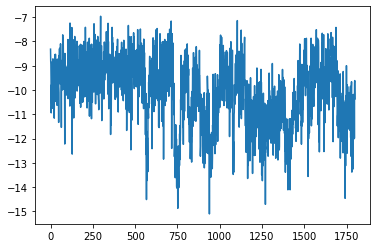

In [4]:
plt.plot(reward_records)

In [7]:
import misc

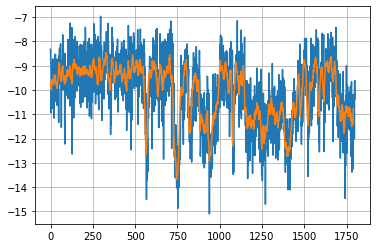

In [12]:
plt.plot(reward_records)
plt.plot(misc.smooth(reward_records,100))
plt.grid()


In [5]:
action

<tf.Tensor: shape=(32, 2), dtype=float32, numpy=
array([[ 0.5902891 , -0.8724587 ],
       [ 0.6427093 , -0.71500593],
       [ 0.66327906, -0.75491273],
       [ 0.5593131 , -0.5723109 ],
       [ 0.53135026, -0.84649634],
       [ 0.46926412, -0.7139148 ],
       [ 0.6088987 , -0.9268548 ],
       [ 0.8200583 , -0.9444096 ],
       [ 0.5404874 , -0.65496916],
       [ 0.6940479 , -0.64261687],
       [ 0.7255678 , -0.6735563 ],
       [ 0.66628164, -0.56956685],
       [ 0.60586196, -0.667749  ],
       [ 0.4283079 , -0.8916841 ],
       [ 0.49911022, -0.760305  ],
       [ 0.43857574, -0.8517035 ],
       [ 0.5845621 , -0.5722463 ],
       [ 0.7007453 , -0.5733619 ],
       [ 0.47615412, -0.7237755 ],
       [ 0.7697588 , -0.7651532 ],
       [ 0.67860657, -0.6911936 ],
       [ 0.53043747, -0.62421614],
       [ 0.5055793 , -0.9289826 ],
       [ 0.8013102 , -0.8986233 ],
       [ 0.49016273, -0.636225  ],
       [ 0.8031125 , -0.787032  ],
       [ 0.69128263, -0.7833471 ],
      

In [6]:
deterministic_action

<tf.Tensor: shape=(32, 2), dtype=float32, numpy=
array([[ 0.6913475 , -0.83881843],
       [ 0.6913475 , -0.83881843],
       [ 0.6913475 , -0.83881843],
       [ 0.6913475 , -0.83881843],
       [ 0.6913475 , -0.83881843],
       [ 0.6913475 , -0.83881843],
       [ 0.6913475 , -0.83881843],
       [ 0.6913475 , -0.83881843],
       [ 0.6913475 , -0.83881843],
       [ 0.6913475 , -0.83881843],
       [ 0.6913475 , -0.83881843],
       [ 0.6913475 , -0.83881843],
       [ 0.6913475 , -0.83881843],
       [ 0.6913475 , -0.83881843],
       [ 0.6913475 , -0.83881843],
       [ 0.6913475 , -0.83881843],
       [ 0.6913475 , -0.83881843],
       [ 0.6913475 , -0.83881843],
       [ 0.6913475 , -0.83881843],
       [ 0.6913475 , -0.83881843],
       [ 0.6913475 , -0.83881843],
       [ 0.6913475 , -0.83881843],
       [ 0.6913475 , -0.83881843],
       [ 0.6913475 , -0.83881843],
       [ 0.6913475 , -0.83881843],
       [ 0.6913475 , -0.83881843],
       [ 0.6913475 , -0.83881843],
      

In [15]:
np.product(prev_state.shape)

1607072

In [16]:
prev_state.shape

(32, 50221)

In [17]:
big_test_array = np.random.normal(size=(10000,50221))

In [18]:
big_test_array2 = np.random.normal(size=(10000,50221))

In [19]:
bigbig = big_test_array + big_test_array2